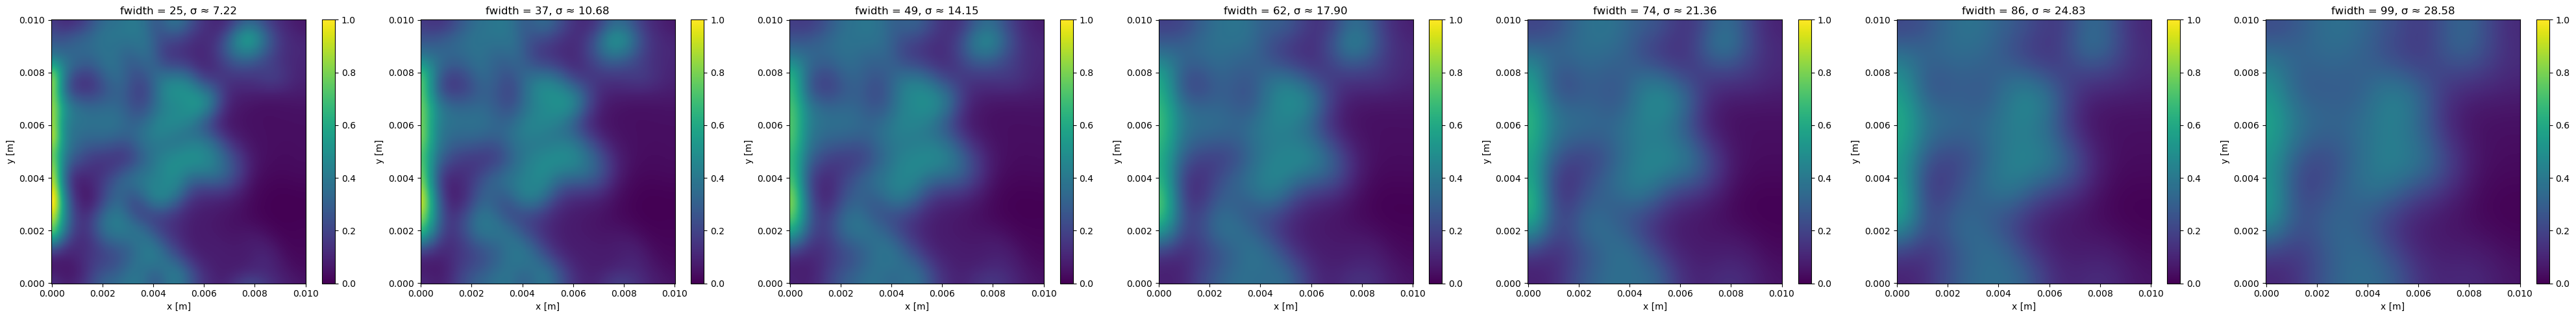

In [24]:
# library
import numpy as np
import matplotlib.pyplot as plt
import scipy

# spatial constants
nx, ny = 384, 384
lx, ly = 0.01, 0.01  # [m]
dx, dy = lx / (nx - 1), ly / (ny - 1)
x = np.arange(0, lx + dx, dx)
y = np.arange(0, ly + dy, dy)

# flame related constants
fwidth_n = np.array([25, 37, 49, 62, 74, 86, 99])

# load raw data
data_path = "bar-wtemp-slice-B1-0000080000-049.raw"
data_orig = np.fromfile(data_path, count=-1, dtype=np.float64).reshape(nx, ny)

# Pre-filter all datasets and normalize globally
filtered_normalized = []
global_min, global_max = np.inf, -np.inf

# First pass: compute all filtered data and track global min/max
for fwidth in fwidth_n:
    sigma = fwidth / np.sqrt(12.0)
    data_filtered = scipy.ndimage.gaussian_filter(data_orig, sigma=sigma, mode='reflect', radius=100)
    global_min = min(global_min, np.min(data_filtered))
    global_max = max(global_max, np.max(data_filtered))
    filtered_normalized.append(data_filtered)

# Normalize to [0, 1]
filtered_normalized = [(d - global_min) / (global_max - global_min) for d in filtered_normalized]

# Create figure and subplots
plt.figure(figsize=(40, 5))

for i, (fwidth, data_norm) in enumerate(zip(fwidth_n, filtered_normalized)):
    sigma = fwidth / np.sqrt(12.0)
    
    plt.subplot(1, 7, i + 1)
    mesh = plt.pcolor(x, y, np.moveaxis(data_norm, (0, 1), (1, 0)),
                      cmap='viridis', vmin=0, vmax=1, shading='auto')
    plt.colorbar(mesh)
    plt.title(f"fwidth = {fwidth}, σ ≈ {sigma:.2f}")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")

plt.tight_layout()
plt.savefig("normalized_subplots_with_colorbars.png", dpi=300)
plt.show()


9216/9216 - 5s - 5s/epoch - 582us/step
c:\Users\gogam\miniconda3\envs\d_and_c\python.exe


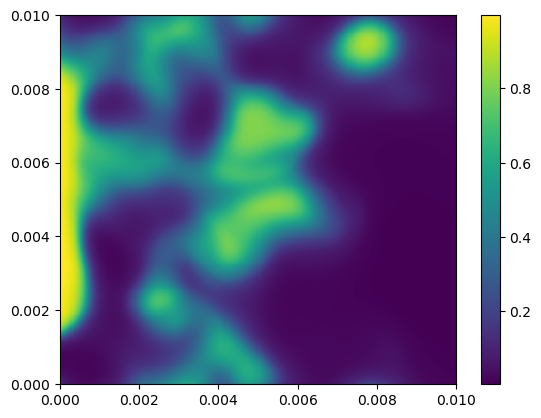

In [ ]:
# library
import numpy as np
import matplotlib.pyplot as plt
import scipy
from keras.models import load_model

# spatial constants
nx, ny = 384, 384
lx, ly = 0.01, 0.01 #[m]
dx, dy = lx/(nx-1), ly/(ny-1)
x = np.arange(0,lx+dx,dx)
y = np.arange(0,ly+dy,dy)

# flame related constants
TU = 1500.000 # K
TB = 1623.47 # K
DTH = 0.0012904903 # m
DU = 0.2219636 # kg/m^3
SL = 1.6585735551 # m/s

# normalization
CT_NORM = TB - TU
WCT_NORM = DU * SL / DTH
NCT_NORM = 1.0 / DTH

# data load
data_1_path = 'bar-wtemp-slice-B1-0000080000-049.raw'
data_1 = np.fromfile( data_1_path, count=-1, dtype=np.float64).reshape(-1,1)

data_2_path = 'tilde-nablatemp-slice-B1-0000080000-049.raw'
data_2 = np.fromfile( data_2_path, count=-1, dtype=np.float64).reshape(-1,1)

#Filter size variable
data_3 = np.zeros(np.shape(data_1))
data_3[:,0] = 0.5 * DTH

#non-dimensionalization
data_1 = data_1 / CT_NORM / WCT_NORM
data_2 = data_2 / CT_NORM / NCT_NORM
data_3 = data_3 / (2.0 * DTH)

# make X
X = np.concatenate((data_1.reshape(-1,1), data_2.reshape(-1,1), data_3.reshape(-1,1)), axis=1)

# model load
model = load_model('phi_nn_converted_model')


# prediction
phi_nn = np.zeros((np.shape(X)[0]))
phi_nn = model.predict(X, batch_size=16, verbose=2).reshape(nx, ny)
import sys
print(sys.executable)


# data plot
plt.pcolor(x, y, np.moveaxis(phi_nn, (0,1), (1,0)))
plt.colorbar()